# ***Álgebra abstracta y computacional***
<span style='font-size:large'>**Facultad de Ciencias**</span>

<span style='font-size:large'>**Universidad Nacional de Colombia**</span>

<span style='font-size:large'>**Bogotá, Colombia**</span>

<span style='font-size:large'>**17 de junio de 2025**</span>

# ***Aritmética de grandes números empleando listas enlazadas***

En este proyecto se propone desarrollar en lenguaje C, una biblioteca basada en listas enlazadas para manejar enteros de longitud arbitraria.
 El sistema incluirá operaciones de suma, resta, multiplicación (tanto clásica como Karatsuba), división en base decimal y división binaria
 optimizada

##Descripción del proyecto.


Este trabajo busca crear un módulo en C que represente números enteros de cualquier tamaño mediante listas enlazadas y proporcione las operaciones aritméticas fundamentales:



*   Suma y resta con gestión de acarreo y préstamo.
*   Multiplicación mediante el método tradicional y el algoritmo de Karatsuba.
*   División larga en notación decimal
*   División binaria usando corrimientos y restas sucesivas.



## Introduccion



Los tipos de datos nativos en C imponen un límite al tamaño de los números. Para superarlo, cada dígito o grupo de
 dígitos se almacenará en nodos de una lista enlazada. De este
 modo, se podrá:


 * Ejecutar aritmética decimal con procedimientos con vencionales y Karatsuba.
 * Realizar división larga en base 10 mediante estimación de cociente.
 * Efectuar división a nivel de bits apoyada en desplazamientos y restas condicionales.

## Desarrollo del código


In [ ]:
%%bash
rm -f proyect1.c
touch proyect1.c


### Definición estructura de BigInt

In [ ]:
%%bash
cat << 'EOF' > proyect1.c
#include <time.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdint.h>
#include <stddef.h>
#include <ctype.h>

#define DEC_BASE      1000000000u  // base 10^9
#define DEC_DIGITS    9            // dígitos por bloque


typedef struct Nodo {
    uint32_t valor;       // 0 <= valor < DEC_BASE
    struct Nodo *sig;     // siguiente nodo (más significativo)
} Nodo;

typedef struct {
    int signo;
    Nodo *cabeza;
    size_t longitud;
} BigInt;


EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
BigInt* bg_nuevo(void);
void bg_liberar(BigInt *a);
void bg_prepend(BigInt *a, uint32_t v);
void bg_append(BigInt *a, uint32_t v);
BigInt* bg_desde_cadena(const char *s);
void printBigInt(const BigInt *a);
void printBigIntNodes(const BigInt *a);
int bigInt_compare(const BigInt *a, const BigInt *b);
void test_tiempos(void);

BigInt* sumar(const BigInt *a, const BigInt *b);
void test_suma(void);

void test_bigInt_compare(void);
void test_printBigIntNodes(void);

EOF

### Funcion para crear un nuevo BigInt

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

BigInt* bg_nuevo(void) {
    BigInt *z = malloc(sizeof(BigInt));
    z->signo    = +1;
    z->cabeza   = NULL;
    z->longitud = 0;
    return z;
}

EOF

### Funcion para liberar la memoria de un BigInt

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

void bg_liberar(BigInt *a) {
    Nodo *p = a->cabeza;
    while (p) {
        Nodo *s = p->sig;
        free(p);
        p = s;
    }
    free(a);
}

EOF

### Insertar nodo al inicio


In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
// Inserta un bloque al inicio (más bajo peso)
void bg_prepend(BigInt *a, uint32_t v) {
    Nodo *n = malloc(sizeof(Nodo));
    n->valor = v;
    n->sig   = a->cabeza;
    a->cabeza = n;
    a->longitud++;
}
EOF

### Insertar nodo al **final**


In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

void bg_append(BigInt *a, uint32_t v) {
    Nodo *n = malloc(sizeof(Nodo));
    n->valor = v;
    n->sig   = NULL;
    if (!a->cabeza) {
        a->cabeza = n;
    } else {
        Nodo *q = a->cabeza;
        while (q->sig) q = q->sig;
        q->sig = n;
    }
    a->longitud++;
}

EOF

### Construye un BigInt desde una cadena decimal



In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

BigInt* bg_desde_cadena(const char *s) {
    BigInt *r = bg_nuevo();
    if (*s=='+'||*s=='-') {
        if (*s=='-') r->signo = -1;
        s++;
    }
    size_t len = strlen(s);
    for (int i = (int)len; i > 0; i -= DEC_DIGITS) {
        int start = i - DEC_DIGITS;
        if (start < 0) start = 0;
        char buf[DEC_DIGITS+1] = {0};
        memcpy(buf, s + start, i - start);
        uint32_t bloque = (uint32_t)atoi(buf);
        bg_append(r, bloque);
    }
    if (r->longitud == 0)
        bg_append(r, 0);
    return r;
}

EOF

## Imprime BigInt

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

void printBigInt(const BigInt *a) {
    uint32_t *bloques = malloc(a->longitud * sizeof(uint32_t));
    size_t n = 0;
    for (Nodo *p = a->cabeza; p; p = p->sig)
        bloques[n++] = p->valor;

    if (a->signo < 0) putchar('-');
    printf("%u", bloques[n-1]);
    for (int i = (int)n-2; i >= 0; i--)
        printf("%09u", bloques[i]);
    putchar('\n');
    free(bloques);
}

EOF

## Imprime BigInt por nodos

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

void printBigIntNodes(const BigInt *a) {
    int idx = 0;
    for (Nodo *p = a->cabeza; p; p = p->sig) {
        printf("  Nodo %2d: %0*u\n",
               idx++, DEC_DIGITS, p->valor);
    }
}

EOF

## Comparar dos BigInt

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
static int compararMagnitud(const Nodo *na, const Nodo *nb, size_t longitud) {
    uint32_t *valores_a = malloc(longitud * sizeof(uint32_t));
    uint32_t *valores_b = malloc(longitud * sizeof(uint32_t));

    const Nodo *pa = na, *pb = nb;
    for (size_t i = 0; i < longitud; i++) {
        valores_a[i] = pa->valor;
        valores_b[i] = pb->valor;
        pa = pa->sig;
        pb = pb->sig;
    }

    for (int i = (int)longitud - 1; i >= 0; i--) {
        if (valores_a[i] > valores_b[i]) {
            free(valores_a);
            free(valores_b);
            return 1;
        }
        if (valores_a[i] < valores_b[i]) {
            free(valores_a);
            free(valores_b);
            return -1;
        }
    }

    free(valores_a);
    free(valores_b);
    return 0;
}

int compararBigInt(const BigInt *a, const BigInt *b) {
    if (a->signo > b->signo) return 1;
    if (a->signo < b->signo) return -1;

    if (a->longitud > b->longitud) return a->signo;
    if (a->longitud < b->longitud) return -a->signo;

    int comparacion = compararMagnitud(a->cabeza, b->cabeza, a->longitud);
    return a->signo < 0 ? -comparacion : comparacion;
}

EOF

## Función auxiliar suma

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

// Función auxiliar para sumar magnitudes (sin considerar signos)
static BigInt* sumarMagnitudes(const BigInt *a, const BigInt *b) {
    BigInt *resultado = bg_nuevo();
    const Nodo *pa = a->cabeza;
    const Nodo *pb = b->cabeza;
    uint64_t acarreo = 0;

    // Sumar mientras ambos nodos existan
    while (pa && pb) {
        uint64_t suma = (uint64_t)pa->valor + (uint64_t)pb->valor + acarreo;
        bg_append(resultado, (uint32_t)(suma % DEC_BASE));
        acarreo = suma / DEC_BASE;
        pa = pa->sig;
        pb = pb->sig;
    }

    // Procesar nodos restantes de a
    while (pa) {
        uint64_t suma = (uint64_t)pa->valor + acarreo;
        bg_append(resultado, (uint32_t)(suma % DEC_BASE));
        acarreo = suma / DEC_BASE;
        pa = pa->sig;
    }

    // Procesar nodos restantes de b
    while (pb) {
        uint64_t suma = (uint64_t)pb->valor + acarreo;
        bg_append(resultado, (uint32_t)(suma % DEC_BASE));
        acarreo = suma / DEC_BASE;
        pb = pb->sig;
    }

    // Agregar acarreo final si existe
    if (acarreo > 0) {
        bg_append(resultado, (uint32_t)acarreo);
    }

    return resultado;
}

EOF

## Función auxiliar resta

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

// Función auxiliar para restar magnitudes (a >= b en magnitud)
static BigInt* restarMagnitudes(const BigInt *a, const BigInt *b) {
    BigInt *resultado = bg_nuevo();
    const Nodo *pa = a->cabeza;
    const Nodo *pb = b->cabeza;
    int64_t prestamo = 0;

    // Restar mientras ambos nodos existan
    while (pa && pb) {
        int64_t resta = (int64_t)pa->valor - (int64_t)pb->valor - prestamo;
        if (resta < 0) {
            resta += DEC_BASE;
            prestamo = 1;
        } else {
            prestamo = 0;
        }
        bg_append(resultado, (uint32_t)resta);
        pa = pa->sig;
        pb = pb->sig;
    }

    // Procesar nodos restantes de a
    while (pa) {
        int64_t resta = (int64_t)pa->valor - prestamo;
        if (resta < 0) {
            resta += DEC_BASE;
            prestamo = 1;
        } else {
            prestamo = 0;
        }
        bg_append(resultado, (uint32_t)resta);
        pa = pa->sig;
    }

    return resultado;
}

EOF

## Función principal suma

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

// Función principal de suma
BigInt* sumar(const BigInt *a, const BigInt *b) {
    BigInt *resultado;

    // Caso 1: Ambos números tienen el mismo signo
    if (a->signo == b->signo) {
        resultado = sumarMagnitudes(a, b);
        resultado->signo = a->signo;
    }
    // Caso 2: Signos diferentes - efectivamente una resta
    else {
        // Comparar magnitudes para determinar el resultado
        size_t max_len = a->longitud > b->longitud ? a->longitud : b->longitud;

        // Expandir temporalmente las listas para comparar
        int comparacion;
        if (a->longitud > b->longitud) {
            comparacion = 1;
        } else if (a->longitud < b->longitud) {
            comparacion = -1;
        } else {
            // Misma longitud, comparar nodo por nodo desde el más significativo
            comparacion = compararMagnitud(a->cabeza, b->cabeza, max_len);
        }

        if (comparacion == 0) {
            // |a| == |b|, resultado es cero
            resultado = bg_nuevo();
            bg_append(resultado, 0);
        }
        else if (comparacion > 0) {
            // |a| > |b|
            resultado = restarMagnitudes(a, b);
            resultado->signo = a->signo;
        }
        else {
            // |a| < |b|
            resultado = restarMagnitudes(b, a);
            resultado->signo = b->signo;
        }
    }

    return resultado;
}

EOF

## Multiplicación usual

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
BigInt* multiplicar(const BigInt *a, const BigInt *b) {
    BigInt *resultado = bg_nuevo();
    bg_append(resultado, 0);

    const Nodo *pb = b->cabeza;
    int despl_b = 0;

    while (pb) {
        const Nodo *pa = a->cabeza;
        uint64_t acarreo = 0;

        BigInt *parcial = bg_nuevo();

        for (int i = 0; i < despl_b; i++) {
            bg_append(parcial, 0);
        }

        while (pa) {
            uint64_t producto = (uint64_t)pa->valor * (uint64_t)pb->valor + acarreo;
            bg_append(parcial, (uint32_t)(producto % DEC_BASE));
            acarreo = producto / DEC_BASE;
            pa = pa->sig;
        }

        if (acarreo > 0)
            bg_append(parcial, (uint32_t)acarreo);

        BigInt *nuevo_res = sumar(resultado, parcial);
        bg_liberar(resultado);
        bg_liberar(parcial);
        resultado = nuevo_res;

        pb = pb->sig;
        despl_b++;
    }

    resultado->signo = a->signo * b->signo;
    return resultado;
}

EOF

## Karatsuba

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

//Clona un BigInt completo:
BigInt* bg_clone(const BigInt *a) {
    BigInt *r = bg_nuevo();
    r->signo = a->signo;
    for (Nodo *p = a->cabeza; p; p = p->sig)
        bg_append(r, p->valor);
    return r;
}

//Desplaza un BigInt por 'bloques' posiciones (multiplica por DEC_BASE^bloques):
BigInt* bg_shift(const BigInt *a, size_t bloques) {
    BigInt *r = bg_clone(a);
    for (size_t i = 0; i < bloques; i++)
        bg_prepend(r, 0);
    return r;
}

//Suma dos BigInt asumiendo magnitud:
BigInt* bg_sumar_magnitud(const BigInt *a, const BigInt *b) {
    // Crear copias temporales con signo positivo
    BigInt *temp_a = bg_clone(a);
    BigInt *temp_b = bg_clone(b);
    temp_a->signo = 1;
    temp_b->signo = 1;

    BigInt *resultado = sumar(temp_a, temp_b);

    bg_liberar(temp_a);
    bg_liberar(temp_b);
    return resultado;
}

//Resta b de a, asumiendo a >= b en magnitud:
BigInt* bg_restar_magnitud(const BigInt *a, const BigInt *b) {
    // Crear copias temporales
    BigInt *temp_a = bg_clone(a);
    BigInt *temp_b = bg_clone(b);
    temp_a->signo = 1;
    temp_b->signo = -1;  // Hacer b negativo para que suma haga resta

    BigInt *resultado = sumar(temp_a, temp_b);

    bg_liberar(temp_a);
    bg_liberar(temp_b);
    return resultado;
}

// Función para dividir un BigInt en dos partes
void bg_split(const BigInt *orig, size_t m, BigInt **pLow, BigInt **pHigh) {
    *pLow  = bg_nuevo();
    *pHigh = bg_nuevo();
    (*pLow)->signo  = orig->signo;
    (*pHigh)->signo = orig->signo;

    Nodo *p = orig->cabeza;
    size_t idx = 0;
    while (p) {
        if (idx < m)
            bg_append(*pLow, p->valor);
        else
            bg_append(*pHigh, p->valor);
        p = p->sig;
        idx++;
    }

    // Si pHigh está vacío, agregar un 0
    if ((*pHigh)->longitud == 0) {
        bg_append(*pHigh, 0);
    }
}

//Multiplicación con Karatsuba:
BigInt* bg_multiplicarKaratsuba(const BigInt *a, const BigInt *b) {
    //Caso base: si es muy pequeño, usar naive
    const size_t UMBRAL = 2;
    if (a->longitud <= UMBRAL || b->longitud <= UMBRAL) {
        return multiplicar(a, b);
    }

    // Usar la longitud del número más grande para m
    size_t max_len = (a->longitud > b->longitud) ? a->longitud : b->longitud;
    size_t m = max_len / 2;

    //Partir a y b en baja/alta:
    BigInt *lowA, *highA, *lowB, *highB;
    bg_split(a, m, &lowA, &highA);
    bg_split(b, m, &lowB, &highB);

    //3 productos recursivos
    BigInt *z0 = bg_multiplicarKaratsuba(lowA, lowB);        // low * low
    BigInt *z2 = bg_multiplicarKaratsuba(highA, highB);      // high * high

    // (lowA + highA) * (lowB + highB)
    BigInt *sumA = bg_sumar_magnitud(lowA, highA);
    BigInt *sumB = bg_sumar_magnitud(lowB, highB);
    BigInt *z1_temp = bg_multiplicarKaratsuba(sumA, sumB);

    //z1 = z1_temp - z2 - z0
    BigInt *temp1 = bg_restar_magnitud(z1_temp, z2);
    BigInt *z1 = bg_restar_magnitud(temp1, z0);

    //r = z2 * BASE^(2m) + z1 * BASE^m + z0
    BigInt *z2_shifted = bg_shift(z2, 2*m);
    BigInt *z1_shifted = bg_shift(z1, m);

    BigInt *temp_sum1 = sumar(z2_shifted, z1_shifted);
    BigInt *resultado = sumar(temp_sum1, z0);

    resultado->signo = a->signo * b->signo;

    // Liberar memoria
    bg_liberar(lowA);  bg_liberar(highA);
    bg_liberar(lowB);  bg_liberar(highB);
    bg_liberar(z0);    bg_liberar(z2);
    bg_liberar(sumA);  bg_liberar(sumB);
    bg_liberar(z1_temp); bg_liberar(temp1);
    bg_liberar(z1);
    bg_liberar(z2_shifted); bg_liberar(z1_shifted);
    bg_liberar(temp_sum1);

    return resultado;
}

EOF

## División larga

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

// Devuelve 1 si BigInt a es cero
int bg_es_cero(const BigInt *a) {
    return (a->longitud == 1 && a->cabeza->valor == 0);
}

// Devuelve un BigInt con valor cero
BigInt* bg_cero() {
    BigInt *r = bg_nuevo();
    bg_append(r, 0);
    return r;
}

// Devuelve un BigInt con valor uno
BigInt* bg_uno() {
    BigInt *r = bg_nuevo();
    bg_append(r, 1);
    return r;
}

// División larga usando multiplicación clásica
BigInt* bg_dividir_largo(const BigInt *dividendo, const BigInt *divisor, BigInt **residuo) {
    if (bg_es_cero(divisor)) {
        fprintf(stderr, "Error: División por cero\n");
        exit(1);
    }
    if (bg_es_cero(dividendo)) {
        if (residuo) *residuo = bg_cero();
        return bg_cero();
    }

    BigInt *dividendo_pos = bg_clone(dividendo);
    BigInt *divisor_pos = bg_clone(divisor);
    dividendo_pos->signo = 1;
    divisor_pos->signo = 1;

    int cmp = compararBigInt(dividendo_pos, divisor_pos);
    if (cmp < 0) {
        if (residuo) *residuo = dividendo_pos;
        bg_liberar(divisor_pos);
        return bg_cero();
    }

    BigInt *cociente = bg_nuevo();
    BigInt *resto = bg_cero();

    Nodo *p = dividendo_pos->cabeza;
    uint32_t *digitos = malloc(dividendo_pos->longitud * sizeof(uint32_t));
    if (!digitos) {
        fprintf(stderr, "Error: no se pudo reservar memoria\n");
        exit(1);
    }
    for (size_t i = 0; i < dividendo_pos->longitud; i++) {
        digitos[i] = p->valor;
        p = p->sig;
    }

    for (int i = (int)dividendo_pos->longitud - 1; i >= 0; i--) {
        BigInt *nuevo_resto = bg_shift(resto, 1);
        bg_liberar(resto);
        resto = nuevo_resto;

        BigInt *extra = bg_nuevo();
        bg_append(extra, digitos[i]);
        BigInt *tmp = sumar(resto, extra);
        bg_liberar(resto);
        bg_liberar(extra);
        resto = tmp;

        // Estimar q
        uint32_t q = 0;
        if (compararBigInt(resto, divisor_pos) >= 0) {
            // Estimar q aproximado
            Nodo *r_top = resto->cabeza;
            while (r_top && r_top->sig) r_top = r_top->sig;
            Nodo *d_top = divisor_pos->cabeza;
            while (d_top && d_top->sig) d_top = d_top->sig;

            uint64_t r_val = r_top ? r_top->valor : 0;
            uint64_t d_val = d_top ? d_top->valor : 1;
            if (d_val == 0) d_val = 1;

            q = (uint32_t)(r_val / d_val);
            if (q == 0) q = 1;

            // Ajustar q si nos pasamos
            BigInt *q_big = bg_nuevo();
            bg_append(q_big, q);

            BigInt *q_mul = multiplicar(divisor_pos, q_big);
            while (compararBigInt(resto, q_mul) < 0) {
                bg_liberar(q_mul);
                bg_liberar(q_big);
                q--;
                q_big = bg_nuevo();
                bg_append(q_big, q);
                q_mul = multiplicar(divisor_pos, q_big);
            }

            BigInt *tmp2 = bg_restar_magnitud(resto, q_mul);
            bg_liberar(resto);
            resto = tmp2;

            bg_liberar(q_mul);
            bg_liberar(q_big);
        }

        bg_append(cociente, q);
    }

    free(digitos);
    bg_liberar(dividendo_pos);
    bg_liberar(divisor_pos);

    cociente->signo = dividendo->signo * divisor->signo;
    resto->signo = dividendo->signo;

    if (residuo) {
        *residuo = resto;
    } else {
        bg_liberar(resto);
    }

    return cociente;
}

EOF

## Pruebas

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
// Genera un BigInt con longitud aleatoria entre min_dig y max_dig dígitos
static BigInt* random_bigint(size_t min_dig, size_t max_dig) {
    size_t len = min_dig + rand() % (max_dig - min_dig + 1);
    char *buf = malloc(len + 1);
    if (!buf) {
        fprintf(stderr, "Error allocando buffer\n");
        exit(EXIT_FAILURE);
    }

    // Primer dígito no cero
    buf[0] = '1' + rand() % 9;
    for (size_t i = 1; i < len; ++i) {
        buf[i] = '0' + rand() % 10;
    }
    buf[len] = '\0';

    BigInt *r = bg_desde_cadena(buf);
    free(buf);
    return r;
}
EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
//Función de prueba para comparar Bigint
void test_compararBigInt() {
    BigInt *a = bg_desde_cadena("12345678901234567890");
    BigInt *b = bg_desde_cadena("12345678901234567890");
    BigInt *c = bg_desde_cadena("98765432109876543210");
    BigInt *d = bg_desde_cadena("-12345678901234567890");

    printf("a vs b: %d (esperado 0)\n", compararBigInt(a, b));
    printf("a vs c: %d (esperado -1)\n", compararBigInt(a, c));
    printf("c vs a: %d (esperado 1)\n", compararBigInt(c, a));
    printf("a vs d: %d (esperado 1)\n", compararBigInt(a, d));
    printf("d vs a: %d (esperado -1)\n", compararBigInt(d, a));
    printf("d vs d: %d (esperado 0)\n", compararBigInt(d, d));

    bg_liberar(a);
    bg_liberar(b);
    bg_liberar(c);
    bg_liberar(d);
}
EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

void test_printBigIntNodes() {
    BigInt *x = bg_desde_cadena("123456789012345678901234567890");
    printf("x completo: ");
    printBigInt(x);
    printf("Imprimiendo nodos de x:\n");
    printBigIntNodes(x);

    BigInt *y = bg_desde_cadena("-98765432109876543210");
    printf("\ny completo: ");
    printBigInt(y);
    printf("Imprimiendo nodos de y:\n");
    printBigIntNodes(y);

    BigInt *z = bg_nuevo();
    bg_append(z, 3);
    bg_prepend(z, 2);
    bg_prepend(z, 1);
    printf("\nz completo: ");
    printBigInt(z);
    printf("Imprimiendo nodos de z:\n");
    printBigIntNodes(z);

    bg_liberar(x);
    bg_liberar(y);
    bg_liberar(z);
}
EOF


In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

// Función de prueba para la suma
void test_suma() {
    printf("\nSumas: \n");

    // Prueba 1: Suma de números positivos
    BigInt *a1 = bg_desde_cadena("123456789012345678901234567890");
    BigInt *b1 = bg_desde_cadena("987654321098765432109876543210");
    BigInt *suma1 = sumar(a1, b1);
    printf("Suma 1: ");
    printBigInt(a1);
    printf("    +   ");
    printBigInt(b1);
    printf("    =   ");
    printBigInt(suma1);
    printf("\n");

    // Prueba 2: Suma con números negativos
    BigInt *a2 = bg_desde_cadena("-123456789");
    BigInt *b2 = bg_desde_cadena("-987654321");
    BigInt *suma2 = sumar(a2, b2);
    printf("Suma 2: ");
    printBigInt(a2);
    printf("    +   ");
    printBigInt(b2);
    printf("    =   ");
    printBigInt(suma2);
    printf("\n");

    // Prueba 3: Suma de positivo y negativo (resta efectiva)
    BigInt *a3 = bg_desde_cadena("1000000000000000000");
    BigInt *b3 = bg_desde_cadena("-999999999999999999");
    BigInt *suma3 = sumar(a3, b3);
    printf("Suma 3: ");
    printBigInt(a3);
    printf("    +   ");
    printBigInt(b3);
    printf("    =   ");
    printBigInt(suma3);
    printf("\n");

    // Prueba 4: Suma que resulta en cero
    BigInt *a4 = bg_desde_cadena("123456789");
    BigInt *b4 = bg_desde_cadena("-123456789");
    BigInt *suma4 = sumar(a4, b4);
    printf("Suma 4: ");
    printBigInt(a4);
    printf("    +   ");
    printBigInt(b4);
    printf("    =   ");
    printBigInt(suma4);
    printf("\n");

    // Liberar memoria
    bg_liberar(a1); bg_liberar(b1); bg_liberar(suma1);
    bg_liberar(a2); bg_liberar(b2); bg_liberar(suma2);
    bg_liberar(a3); bg_liberar(b3); bg_liberar(suma3);
    bg_liberar(a4); bg_liberar(b4); bg_liberar(suma4);
}

EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

// Función de prueba de multiplicación clásica vs Karatsuba
void test_multiplicar(void) {
    srand((unsigned)time(NULL));

    // --- Caso fijo ---
    printf("\n=== Prueba fija de multiplicación ===\n");
    BigInt *a1 = bg_desde_cadena(
        "314159265358979323846264338327950288419716939937510"
    );
    BigInt *b1 = bg_desde_cadena(
        "271828182845904523536028747135266249775724709369995"
    );

    printf("a1 = "); printBigInt(a1);
    printf("b1 = "); printBigInt(b1);

    BigInt *r1_naive = multiplicar(a1, b1);
    BigInt *r1_kar   = bg_multiplicarKaratsuba(a1, b1);

    printf("Resultado Naive:     "); printBigInt(r1_naive);
    printf("Resultado Karatsuba: "); printBigInt(r1_kar);

    bg_liberar(a1);
    bg_liberar(b1);
    bg_liberar(r1_naive);
    bg_liberar(r1_kar);

    // --- Caso aleatorio grande ---
    printf("\n=== Prueba aleatoria 2000–3000 dígitos ===\n");
    BigInt *a2 = random_bigint(2000, 3000);
    BigInt *b2 = random_bigint(2000, 3000);

    printf("a2 (%zu dígitos) = ", a2->longitud); printBigInt(a2);
    printf("b2 (%zu dígitos) = ", b2->longitud); printBigInt(b2);

    BigInt *r2_naive = multiplicar(a2, b2);
    BigInt *r2_kar   = bg_multiplicarKaratsuba(a2, b2);

    printf("Resultado Naive (aleatorio):     "); printBigInt(r2_naive);
    printf("Resultado Karatsuba (aleatorio): "); printBigInt(r2_kar);

    bg_liberar(a2);
    bg_liberar(b2);
    bg_liberar(r2_naive);
    bg_liberar(r2_kar);
}

EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
// Función para medir y comparar tiempos de multiplicación clásica vs Karatsuba
void test_tiempos_multiplicar(void) {
    srand((unsigned)time(NULL));
    clock_t start, end;
    double t_naive, t_kar;

    // --- Caso fijo ---
    BigInt *a1 = bg_desde_cadena(
        "314159265358979323846264338327950288419716939937510"
    );
    BigInt *b1 = bg_desde_cadena(
        "271828182845904523536028747135266249775724709369995"
    );

    start = clock();
    BigInt *r1_naive = multiplicar(a1, b1);
    end   = clock();
    t_naive = (double)(end - start) / CLOCKS_PER_SEC;

    start = clock();
    BigInt *r1_kar   = bg_multiplicarKaratsuba(a1, b1);
    end   = clock();
    t_kar   = (double)(end - start) / CLOCKS_PER_SEC;

    printf("\n=== Tiempos Multiplicación (Caso Fijo) ===\n");
    printf("Naive:     %.6f s\n", t_naive);
    printf("Karatsuba: %.6f s\n", t_kar);

    bg_liberar(a1);
    bg_liberar(b1);
    bg_liberar(r1_naive);
    bg_liberar(r1_kar);

    // --- Caso aleatorio grande (2000–3000 dígitos) ---
    BigInt *a2 = random_bigint(2000, 3000);
    BigInt *b2 = random_bigint(2000, 3000);

    start = clock();
    BigInt *r2_naive = multiplicar(a2, b2);
    end   = clock();
    t_naive = (double)(end - start) / CLOCKS_PER_SEC;

    start = clock();
    BigInt *r2_kar   = bg_multiplicarKaratsuba(a2, b2);
    end   = clock();
    t_kar   = (double)(end - start) / CLOCKS_PER_SEC;

    printf("\n=== Tiempos Multiplicación (Caso Aleatorio: %zu dígitos) ===\n",
           a2->longitud);
    printf("Naive:     %.6f s\n", t_naive);
    printf("Karatsuba: %.6f s\n", t_kar);

    bg_liberar(a2);
    bg_liberar(b2);
    bg_liberar(r2_naive);
    bg_liberar(r2_kar);
}
EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c
void test_karatsuba_casos_limite() {
    printf("\n--- Casos límite Karatsuba ---\n");

    BigInt *a, *b, *r;

    // Caso 1: a por 0
    a = bg_desde_cadena("987654321");
    b = bg_desde_cadena("0");
    r = bg_multiplicarKaratsuba(a, b);
    printf("Caso a x 0: "); printBigInt(r);
    bg_liberar(a); bg_liberar(b); bg_liberar(r);

    // Caso 2: a por 1
    a = bg_desde_cadena("987654321");
    b = bg_desde_cadena("1");
    r = bg_multiplicarKaratsuba(a, b);
    printf("Caso a x 1: "); printBigInt(r);
    bg_liberar(a); bg_liberar(b); bg_liberar(r);

    // Caso 3: 1 dígito por 1 dígito
    a = bg_desde_cadena("7");
    b = bg_desde_cadena("8");
    r = bg_multiplicarKaratsuba(a, b);
    printf("Caso 1 dígito: "); printBigInt(r);
    bg_liberar(a); bg_liberar(b); bg_liberar(r);

    // Caso 4: muy grande
    a = random_bigint(1000, 1000);
    b = random_bigint(1000, 1000);
    r = bg_multiplicarKaratsuba(a, b);
    printf("Caso 1000 dígitos OK\n");
    bg_liberar(a); bg_liberar(b); bg_liberar(r);

    // Caso 5: tamaños dispares
    a = random_bigint(100, 100);
    b = random_bigint(2000, 2000);
    r = bg_multiplicarKaratsuba(a, b);
    printf("Caso tamaños dispares OK\n");
    bg_liberar(a); bg_liberar(b); bg_liberar(r);
}
EOF


In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

void test_division() {
    printf("\nTest División larga\n");

    BigInt *a = bg_desde_cadena("123456789012345678901234567890");
    BigInt *b = bg_desde_cadena("1234567890");

    // Puntero para residuo
    BigInt *r = NULL;

    // Calcular división larga
    BigInt *q = bg_dividir_largo(a, b, &r);

    printf("Dividendo: ");
    printBigInt(a);
    printf("\n");

    printf("Divisor: ");
    printBigInt(b);
    printf("\n");

    printf("Cociente: ");
    printBigInt(q);
    printf("\n");

    printf("Residuo: ");
    printBigInt(r);
    printf("\n");

    // Liberar memoria
    bg_liberar(a);
    bg_liberar(b);
    bg_liberar(q);
    bg_liberar(r);
}
EOF

In [ ]:
%%bash
cat << 'EOF' >> proyect1.c

//Modo benchmarking
int main(int argc, char **argv) {
    if (argc == 3 && strcmp(argv[1], "-bench") == 0) {
        int n = atoi(argv[2]);
        srand((unsigned)time(NULL));
        BigInt *a = random_bigint(n, n);
        BigInt *b = random_bigint(n, n);

        clock_t start, end;
        start = clock();
        BigInt *r_naive = multiplicar(a, b);
        end = clock();
        printf("Naive:     %.6f s\n", (double)(end - start)/CLOCKS_PER_SEC);
        bg_liberar(r_naive);

        start = clock();
        BigInt *r_kar = bg_multiplicarKaratsuba(a, b);
        end = clock();
        printf("Karatsuba: %.6f s\n", (double)(end - start)/CLOCKS_PER_SEC);
        bg_liberar(r_kar);

        bg_liberar(a);
        bg_liberar(b);
        return 0;
    }

    test_printBigIntNodes();
    test_compararBigInt();
    test_suma();
    test_multiplicar();
    test_tiempos_multiplicar();
    test_karatsuba_casos_limite();
    test_division();
    return 0;
}
EOF

In [ ]:
%%bash

gcc proyect1.c -o proyect
./proyect

x completo: 123456789012345678901234567890
Imprimiendo nodos de x:
  Nodo  0: 234567890
  Nodo  1: 345678901
  Nodo  2: 456789012
  Nodo  3: 000000123

y completo: -98765432109876543210
Imprimiendo nodos de y:
  Nodo  0: 876543210
  Nodo  1: 765432109
  Nodo  2: 000000098

z completo: 3000000002000000001
Imprimiendo nodos de z:
  Nodo  0: 000000001
  Nodo  1: 000000002
  Nodo  2: 000000003
a vs b: 0 (esperado 0)
a vs c: -1 (esperado -1)
c vs a: 1 (esperado 1)
a vs d: 1 (esperado 1)
d vs a: -1 (esperado -1)
d vs d: 0 (esperado 0)

Sumas: 
Suma 1: 123456789012345678901234567890
    +   987654321098765432109876543210
    =   1111111110111111111011111111100

Suma 2: -123456789
    +   -987654321
    =   -1111111110

Suma 3: 1000000000000000000
    +   -999999999999999999
    =   0000000000000000001

Suma 4: 123456789
    +   -123456789
    =   0


=== Prueba fija de multiplicación ===
a1 = 314159265358979323846264338327950288419716939937510
b1 = 27182818284590452353602874713526624977572470

In [ ]:
%%bash
gcc proyect1.c -o proyect1


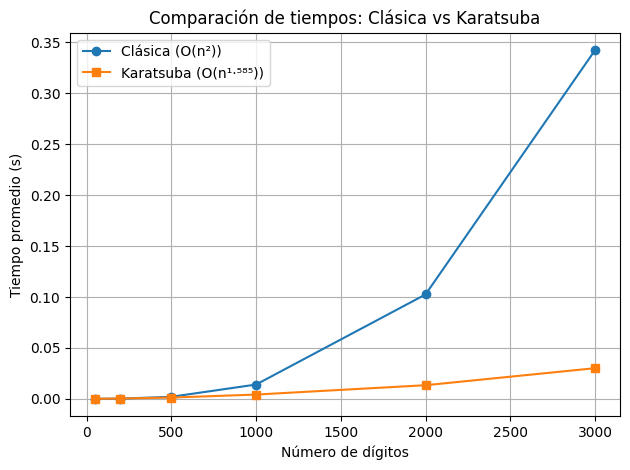

In [ ]:
import subprocess
import re
import statistics
import matplotlib.pyplot as plt

# Tamaños de prueba y repeticiones
sizes = [50, 200, 500, 1000, 2000, 3000]
runs = 10

naive_avg = []
kar_avg = []

for n in sizes:
    nt = []; kt = []
    for _ in range(runs):
        out = subprocess.check_output(['./proyect1', '-bench', str(n)], text=True)
        nt.append(float(re.search(r'Naive:\s+([\d.]+)', out).group(1)))
        kt.append(float(re.search(r'Karatsuba:\s+([\d.]+)', out).group(1)))
    naive_avg.append(statistics.mean(nt))
    kar_avg.append(statistics.mean(kt))

plt.figure()
plt.plot(sizes, naive_avg, marker='o', label='Clásica (O(n²))')
plt.plot(sizes, kar_avg, marker='s', label='Karatsuba (O(n¹·⁵⁸⁵))')
plt.xlabel('Número de dígitos')
plt.ylabel('Tiempo promedio (s)')
plt.title('Comparación de tiempos: Clásica vs Karatsuba')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
